## Test pure-H2 convective shutdown

In [1]:
# Import system packages
using Printf
using DelimitedFiles
using Plots
using LaTeXStrings

In [2]:
# Set directory
ROOT_DIR = abspath(joinpath(pwd(),"../"))
ENV["RAD_DIR"] = joinpath(ROOT_DIR,"socrates")

"/Users/nichollsh/Projects/AGNI/socrates"

In [3]:
# Import AGNI
using AGNI
import AGNI.atmosphere as atmosphere
import AGNI.solver as nl
import AGNI.setpt as setpt
import AGNI.dump as dump
import AGNI.plotting as plotting

# Disable logging from AGNI module
AGNI.setup_logging("",1)

[ Info: Precompiling AGNI [ede838c1-9ec3-4ebe-8ae8-da4091b3f21c]


In [4]:
F_earth = 1361.0
R_earth = 6.371e6
M_earth = 5.97e24

5.97e24

In [5]:
# Configuration options
instellation    = F_earth * 5.0
mass            = M_earth
radius          = R_earth     
gravity         = 6.67e-11 * mass / radius^2
p_surf          = 100.0        

s0_fact         = 0.375  
zenith_degrees  = 48.19 
albedo_s        = 0.3
nlev_centre     = 46
p_top           = 1e-4      # bar 
mole_fractions  = Dict([("H2",  1.0)])
tmp_surf        = 1500.0
thermo          = true

spectral_file = joinpath(ROOT_DIR,"res/spectral_files/nogit/Dayspring/256/Dayspring.sf")
star_file     = joinpath(ROOT_DIR,"res/stellar_spectra/sun.txt")
output_dir    = joinpath(ROOT_DIR,"out/")

"/Users/nichollsh/Projects/AGNI/out/"

In [6]:
# Create output directory
rm(output_dir,force=true,recursive=true)
mkdir(output_dir);

In [7]:
# Setup atmosphere
atmos = atmosphere.Atmos_t()
atmosphere.setup!(atmos, ROOT_DIR, output_dir, 
                        spectral_file,
                        instellation, s0_fact, 0.0, zenith_degrees,
                        tmp_surf,
                        gravity, radius,
                        nlev_centre, p_surf, p_top,
                        mole_fractions, "",
                        flag_gcontinuum=true,
                        flag_rayleigh=true,
                        thermo_functions=thermo,
                        surface_material="blackbody",
                        albedo_s=albedo_s
                    )
atmosphere.allocate!(atmos, star_file)

[ INFO  ] Composition set by dict 
[ INFO  ] Inserting stellar spectrum and Rayleigh coefficients 
[ INFO  ] Allocated atmosphere with composition: 
[ INFO  ]       1 H2      1.00e+00  


In [8]:
setpt.dry_adiabat!(atmos)
setpt.stratosphere!(atmos, 200.0)

In [9]:
solver_success = nl.solve_energy!(atmos, 
                                    sol_type=3,       
                                    sens_heat=true,   
                                    latent=true,      
                                    method=1,         
                                    dx_max=600.0,     
                                    linesearch=true , 
                                    save_frames=false, modplot=1,
                                    conv_atol=0.5,
                                    modprint=2
                                    )
println("Solver success? $solver_success")
atm_base = deepcopy(atmos);

[ INFO  ]     sol_type = 3 
[ INFO  ]     tmp_int  = 0.00 K 
[ INFO  ]     f_int    = 0.00 W m-2 
[ INFO  ]     step  resid_med    cost     flux_OLR   xvals_med  xvals_max  |dx|_max   flags 
[ INFO  ]        2  +4.81e-01  6.767e+02  1.527e+03  +3.19e+02  +1.48e+03  1.698e+02  C2-Nr-Ls 
[ INFO  ]        4  +2.86e-01  1.043e+04  1.506e+03  +3.19e+02  +1.48e+03  2.113e+00  C2-Nr-Ls 


LoadError: InterruptException:

In [ ]:
ins_arr = collect(range(start=1.2, stop=0.2, step=-0.2))
atm_arr = atmosphere.Atmos_t[]

@printf("Running model for %d samples... \n", length(ins_arr))

atmos = deepcopy(atm_base)
for (i,ins) in enumerate(ins_arr)
    @printf("sample %d \n",i)

    atmos.instellation = F_earth * ins
    @printf("    instellation = %.2e W m-2 \n", atmos.instellation)
    
    # Run model
    solver_success = nl.solve_energy!(atmos, 
                                    sol_type=3,         
                                    sens_heat=true,   
                                    latent=true,        
                                    method=1,           
                                    dx_max=20.0,        # Smaller steps
                                    linesearch=false ,   
                                    save_frames=false, modplot=1,
                                    modprint=2, perturb_all=true,
                                    conv_atol=0.4  
                                    )

    # Store result
    push!(atm_arr, deepcopy(atmos))
    @printf("--------------------------------- \n")
end 
println("Done!")

Running model for 5 samples... 
sample 1 
    instellation = 3.40e+03 W m-2 
[ INFO  ]     sol_type = 3 
[ INFO  ]     tmp_int  = 0.00 K 
[ INFO  ]     f_int    = 0.00 W m-2 
[ INFO  ]     step  resid_med    cost     flux_OLR   xvals_med  xvals_max  |dx|_max   flags 
[ INFO  ]        1  -1.07e+00  1.016e+03  1.647e+03  +3.73e+02  +1.37e+03  2.000e+01  C2-Nr 
[ INFO  ]        2  -5.56e-01  6.837e+02  1.534e+03  +3.63e+02  +1.36e+03  2.000e+01  C2-Nr 
[ INFO  ]        3  -5.55e-01  6.832e+02  1.534e+03  +3.63e+02  +1.36e+03  2.000e+01  C2-Nr 
[ INFO  ]        4  -3.28e-01  6.564e+03  1.510e+03  +3.62e+02  +1.36e+03  2.000e+01  C2-Nr 
[ INFO  ]        5  -2.85e-01  2.918e+04  1.420e+03  +3.59e+02  +1.35e+03  2.000e+01  C2-Nr 
[ INFO  ]        6  -2.73e-01  2.797e+04  1.396e+03  +3.56e+02  +1.35e+03  2.000e+01  C2-Nr 
[ INFO  ]        7  -2.70e-01  2.764e+04  1.389e+03  +3.56e+02  +1.35e+03  2.000e+01  C2-Nr 
[ INFO  ]        8  -1.44e-01  2.410e+04  1.314e+03  +3.51e+02  +1.34e+03  2.000e

In [ ]:
fs=12
lw=1.5
ff="Times New Roman"

"Times New Roman"

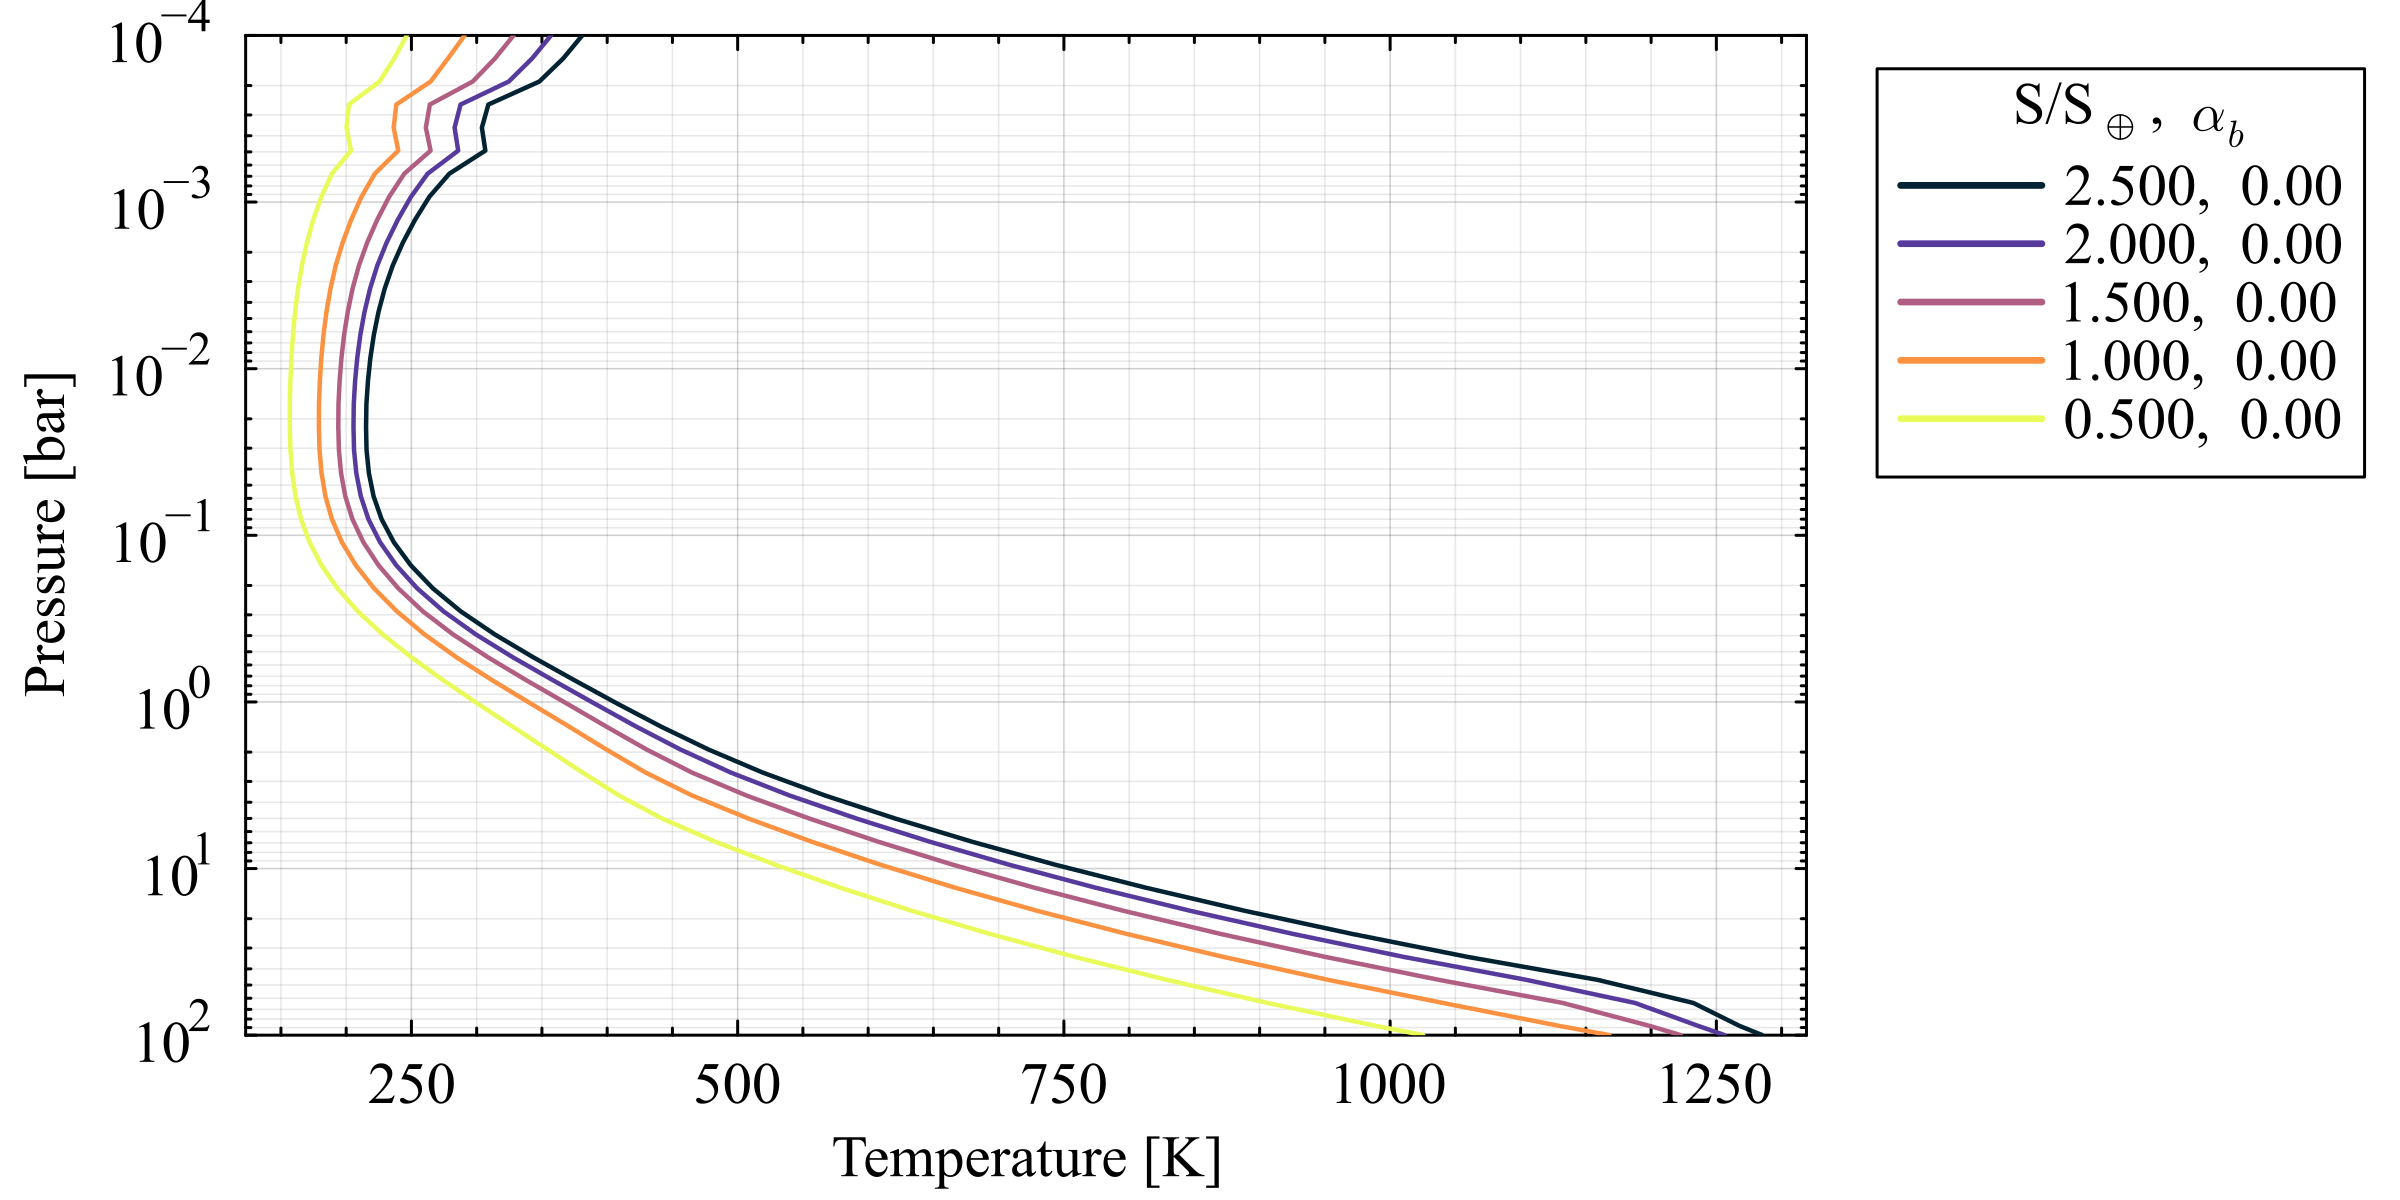

"/Users/nichollsh/Projects/AGNI/out/profiles.pdf"

In [ ]:
arr_P = atmos.pl .* 1.0e-5 # Convert Pa to bar
ylims  = (arr_P[1], arr_P[end])
yticks = 10.0 .^ round.(Int,range( log10(ylims[1]), stop=log10(ylims[2]), step=1))

plt = plot(framestyle=:box, size=(800,400), dpi=300, 
                leg=:outertopright, legcolumn=-1,
                tickfontsize=fs, tickfontfamily=ff,
                guidefontsize=fs, guidefontfamily=ff,
                legendfontfamily=ff, legendfontsize=fs, 
                legendtitlefontfamily=ff, legendtitlefontsize=fs,
                leg_title=L"S/S$_\oplus$,  $\alpha_b$",
                left_margin=4Plots.mm, bottom_margin=4Plots.mm)
          

p = Plots.palette(:thermal_r, length(ins_arr))
for (i,this_atm) in enumerate(atm_arr)
    plot!(plt, this_atm.tmpl, this_atm.pl* 1.0e-5, lc=p[i], linewidth=lw, label=@sprintf("%.3f,  %.2f", ins_arr[i], this_atm.flux_u_sw[1]/this_atm.flux_d_sw[1]))
end 

xlabel!(plt, "Temperature [K]")
xaxis!(plt, minorgrid=true)
ylabel!(plt, "Pressure [bar]")
yflip!(plt)
yaxis!(plt, yscale=:log10, ylims=ylims, yticks=yticks)
display(plt)
savefig(plt,joinpath(output_dir,"profiles.pdf"))

In [ ]:
# for (i, atm) in enumerate(atm_arr)
#     dump.write_ncdf(atm, joinpath(atm.OUT_DIR, "$i.nc"))
# end